In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn.functional as F

In [3]:
words = open('names.txt', 'r').read().split('\n')
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
charset = sorted(list(set(''.join(words))))
charset

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [5]:
stoi = {s:i+1 for i, s in enumerate(charset)}
stoi['.'] = 0

In [6]:
itos = {i:s for s, i in stoi.items()}

In [20]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(89)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182401, 3]) torch.Size([182401])
torch.Size([22778, 3]) torch.Size([22778])
torch.Size([22967, 3]) torch.Size([22967])


In [47]:
g = torch.Generator().manual_seed(2525) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 400), generator=g)
b1 = torch.randn(400, generator=g)
W2 = torch.randn((400, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [48]:
sum(p.nelement() for p in parameters) # number of parameters in total

23497

In [49]:
for p in parameters:
    p.requires_grad = True

In [50]:
lri = []
lossi = []
steps = []

In [51]:
for i in range(32000):

    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (48,))

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    print(loss.item())  

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = -0.01 if i < 10000 else -0.01
    for p in parameters:
        p.data += lr * p.grad

    lri.append(lr)
    lossi.append(loss.log10().item())
    steps.append(i)
   

37.07380294799805
37.483028411865234
35.76474380493164
36.8523063659668
33.63654327392578
33.008819580078125
34.16093826293945
32.68820571899414
34.06317138671875
35.27934646606445
33.0128173828125
32.079105377197266
30.471139907836914
36.02503204345703
31.20173454284668
27.425142288208008
34.094722747802734
26.466842651367188
24.54559326171875
32.38674545288086
26.33036994934082
36.20947265625
32.47866439819336
30.272008895874023
29.086885452270508
33.835838317871094
28.69872283935547
34.86568069458008
32.095760345458984
26.495649337768555
33.30868911743164
27.3436279296875
30.311098098754883
26.04820442199707
22.071792602539062
28.283761978149414
29.511926651000977
28.701797485351562
32.92033767700195
27.86219024658203
25.042341232299805
30.938383102416992
30.299428939819336
30.734018325805664
23.71185302734375
28.123159408569336
27.600149154663086
29.403871536254883
24.293622970581055
24.43821144104004
25.639806747436523
28.586843490600586
25.995141983032227
28.35728645324707
30.061

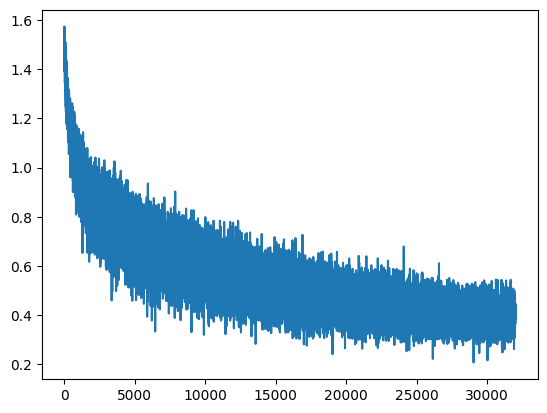

In [52]:
plt.plot(steps, lossi)

In [53]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.4909, grad_fn=<NllLossBackward0>)

In [54]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.5118, grad_fn=<NllLossBackward0>)

In [58]:
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.5247, grad_fn=<NllLossBackward0>)

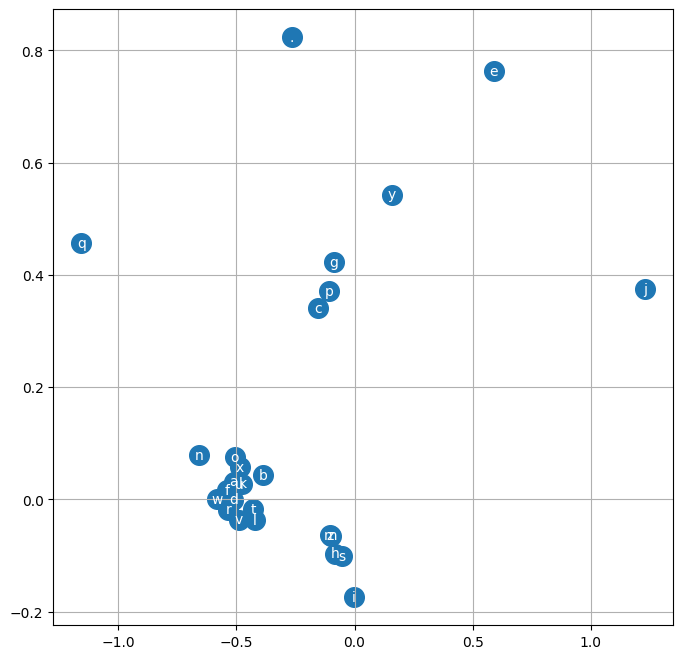

In [55]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [56]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [57]:
# sample from the model
g = torch.Generator().manual_seed(2525 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

caletlee.
zaulie.
jahareylee.
jaran.
onyl.
bina.
yongelen.
ihaisearlrylee.
aakali.
dadie.
voliya.
aih.
dhan.
alie.
ovisauniarah.
kan.
avniel.
kiihdge.
sahar.
talarli.
